# The Caring Home / Helpful Home Continued

A model that can look for non normal situations in a elderly person home, from smart home IoT sensors.

## Enter RAG - Retrieval Augmented Generation!

And now - we put RAG and Frontier Models to the test.

In [2]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
from items import Item
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic

# we need some new includes for our classes
from typing import List, Dict
from agents.agent import Agent
from agents.situations import Situation


In [3]:
# Lets include our sentence transformer
from sentence_transformers import SentenceTransformer, util

In [4]:
# moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)

from testing import Tester

In [5]:
# We will use Ollama locally for some models so we will need requests
import requests

In [6]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['OPENROUTER_API_KEY'] = os.getenv('OPENROUTER_API_KEY', 'your-key-if-not-using-env')
os.environ['HYPERBOLIC_API_KEY'] = os.getenv('HYPERBOLIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [7]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [8]:
openai = OpenAI()
claude = Anthropic()

In [9]:
%matplotlib inline

In [10]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [18]:
# We will use our current memory.json file as the documents 
# as a human has checked over these entries and estimated them

# Lets load the memory.json file
file_path = "data/memory1.json"

def load_json_file(file_path):
    if not os.path.exists(file_path):
        return []
                
    with open(file_path, 'r') as f:
        return json.load(f)

load_json_file(file_path)

[]

In [24]:
# We will use the Sentence Transformer to pick out closest documents

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

def vector_search(file_path, query, top_k=5):
    # Load JSON data
    data = load_json_file(file_path)

    # Extract text data to embed and keep track of indices
    texts = [item['situation']['situation_description'] for item in data]

    # Return an empty list if there are no texts
    if not texts:
        return []
        
    # Create embeddings for each text
    embeddings = model.encode(texts, convert_to_tensor=True)

    # Create embedding for the query
    query_embedding = model.encode(query, convert_to_tensor=True)

    # Compute cosine similarities
    similarities = util.pytorch_cos_sim(query_embedding, embeddings)[0]

    # Get the top_k results
    top_results = similarities.topk(top_k)

    # Return the most similar JSON objects
    return [data[idx] for idx in top_results.indices.tolist()]



In [26]:
# Now check what is returned for bathroom

query = "Events the happen in the bathroom are important to me"
similar_situations = vector_search(file_path, query)
print(similar_situations)

[]


## First, the humble but mighty GPT-4o-mini

Lets try it with RAG

In [27]:
# We need to make the context using the vector search results

def make_context(similars: List[str]) -> str:
    """
    Create context that can be inserted into the prompt
    :param similars: similar situations to the one being estimated
    :param estimates: estimates of the similar situations
    :return: text to insert in the prompt that provides context
    """
    message = "To provide some context, here are some other situations that might be similar to the situations you need to estimate.\n\n"
    for similar in similars:
        details = json.dumps(similar['situation']['details'])
        estimate = similar['estimate']
        message += f"Potentially related situation:\n{details}\nEstimate is {estimate}\n\n"
    return message

def messages_for(situation: Situation, similar_situations: List[Situation]) -> List[Dict[str, str]]:
    """
    Create the message list to be included in a call to OpenAI
    With the system and user prompt
    :param description: a description of the situation to estimate
    :param similars: similar situations to this one
    :param estimates: estimates of similar situations
    :return: the list of messages in the format expected by OpenAI
    """
    system_message = "You look for normal and anomalous situations in smart home sensor data in an elderly persons home. Reply only with the word normal or anomalous, no explanation"
    user_prompt = make_context(similar_situations)
    user_prompt += "And now the situaton for you:\n\n"
    details = situation.details
    user_prompt += "How would you classify this sensor data - normal or anomalous?\n\n" + json.dumps(details)
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Result is "}
    ]


In [28]:
# Try this out
messages_for(test[0], similar_situations)

[{'role': 'system',
  'content': 'You look for normal and anomalous situations in smart home sensor data in an elderly persons home. Reply only with the word normal or anomalous, no explanation'},
 {'role': 'user',
  'content': 'To provide some context, here are some other situations that might be similar to the situations you need to estimate.\n\nAnd now the situaton for you:\n\nHow would you classify this sensor data - normal or anomalous?\n\n"[{\\"timestamp\\": 1738152000, \\"room\\": \\"pillbox\\", \\"nodeId\\": 1, \\"onOff\\": true}, {\\"timestamp\\": 1738152060, \\"room\\": \\"bedroom\\", \\"nodeId\\": 2, \\"onOff\\": true}, {\\"timestamp\\": 1738152300, \\"room\\": \\"bathroom\\", \\"nodeId\\": 2, \\"onOff\\": true}, {\\"timestamp\\": 1738152600, \\"room\\": \\"bathroom\\", \\"nodeId\\": 3, \\"humidity\\": 6500}, {\\"timestamp\\": 1738152900, \\"room\\": \\"bathroom\\", \\"nodeId\\": 2, \\"onOff\\": false}, {\\"timestamp\\": 1738153200, \\"room\\": \\"kitchen\\", \\"nodeId\\": 2

In [34]:
# A utility function to extract the result from a string

def get_result(text):
    # Match "normal" or "anomalous" anywhere in the text
    match = re.search(r"\b(normal|anomalous)\b", text, re.IGNORECASE)
    return match.group(1).lower() if match else None

In [35]:
get_result("The result is anomalous because blah blah")

'anomalous'

In [36]:
get_result("anomalous")

'anomalous'

In [56]:
# Lets get similar situations for a real item
query = test[0].test_prompt()
#print(query)

similar_situations = vector_search(file_path, query)
print(similar_situations)

[{'situation': {'situation_description': "The individual exhibited an alarming pattern of extended inactivity in the kitchen and bedroom without any log entries indicating movement or use of monitored devices. The kitchen was occupied for an extended time, suggesting possible difficulty. Additionally, prolonged delays between entries could indicate a lack of actions that signal normal daily routines. This situation may require immediate monitoring to ensure the elderly person's well-being.", 'result': 'anomalous', 'start_timestamp': 1738009200, 'end_timestamp': 1738029600, 'details': ['{"timestamp": 1738009200, "room": "kitchen", "nodeId": 2, "onOff": false}', '{"timestamp": 1738011600, "room": "livingroom", "nodeId": 2, "onOff": true}', '{"timestamp": 1738015200, "room": "livingroom", "nodeId": 2, "onOff": false}', '{"timestamp": 1738018800, "room": "bedroom", "nodeId": 2, "onOff": true}', '{"timestamp": 1738018860, "room": "pillbox", "nodeId": 1, "onOff": true}', '{"timestamp": 17380

In [60]:
messages_for(test[0], similar_situations)

[{'role': 'system',
  'content': 'You look for normal and anomalous situations in smart home sensor data in an elderly persons home. Reply only with the word normal or anomalous, no explanation'},
 {'role': 'user',
  'content': 'To provide some context, here are some other situations that might be similar to the situations you need to estimate.\n\nPotentially related situation:\n["{\\"timestamp\\": 1738009200, \\"room\\": \\"kitchen\\", \\"nodeId\\": 2, \\"onOff\\": false}", "{\\"timestamp\\": 1738011600, \\"room\\": \\"livingroom\\", \\"nodeId\\": 2, \\"onOff\\": true}", "{\\"timestamp\\": 1738015200, \\"room\\": \\"livingroom\\", \\"nodeId\\": 2, \\"onOff\\": false}", "{\\"timestamp\\": 1738018800, \\"room\\": \\"bedroom\\", \\"nodeId\\": 2, \\"onOff\\": true}", "{\\"timestamp\\": 1738018860, \\"room\\": \\"pillbox\\", \\"nodeId\\": 1, \\"onOff\\": true}", "{\\"timestamp\\": 1738019400, \\"room\\": \\"bedroom\\", \\"nodeId\\": 2, \\"onOff\\": false}", "{\\"timestamp\\": 1738029600, \

In [57]:
# The function for gpt-4o-mini

def gpt_4o_mini(item):
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item, similar_situations),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_result(reply)

In [58]:
test[0].result

'anomalous'

1: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1738152000, "room": "pill...
2: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1738695600, "room": "bath...
3: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1738411200, "room": "pill...
4: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1738843200, "room": "pill...
5: Guess: anomalous Truth: normal Error: True Item: [{"timestamp": 1738238400, "room": "pill...
6: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1739078400, "room": "bath...
7: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1738843200, "room": "pill...
8: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1738627200, "room": "livi...
9: Guess: anomalous Truth: normal Error: True Item: [{"timestamp": 1738756800, "room": "pill...
10: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1739203200, "room": "bath...
11: Guess: normal Truth

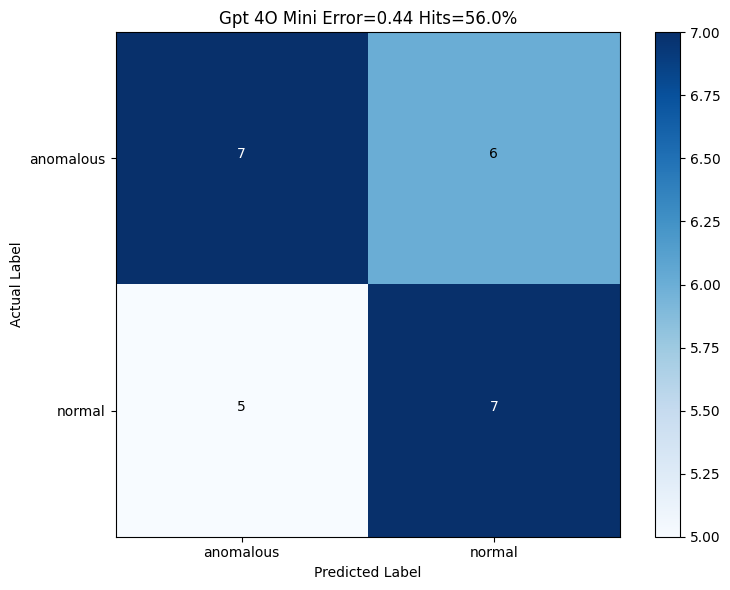

In [59]:
Tester.test(gpt_4o_mini, test)

In [61]:
def gpt_4o_frontier(item):
    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06", 
        messages=messages_for(item, similar_situations),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_result(reply)

1: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1738152000, "room": "pill...
2: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1738695600, "room": "bath...
3: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1738411200, "room": "pill...
4: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1738843200, "room": "pill...
5: Guess: anomalous Truth: normal Error: True Item: [{"timestamp": 1738238400, "room": "pill...
6: Guess: anomalous Truth: normal Error: True Item: [{"timestamp": 1739078400, "room": "bath...
7: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1738843200, "room": "pill...
8: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1738627200, "room": "livi...
9: Guess: anomalous Truth: normal Error: True Item: [{"timestamp": 1738756800, "room": "pill...
10: Guess: anomalous Truth: normal Error: True Item: [{"timestamp": 1739203200, "room": "bath...
11: Guess: anom

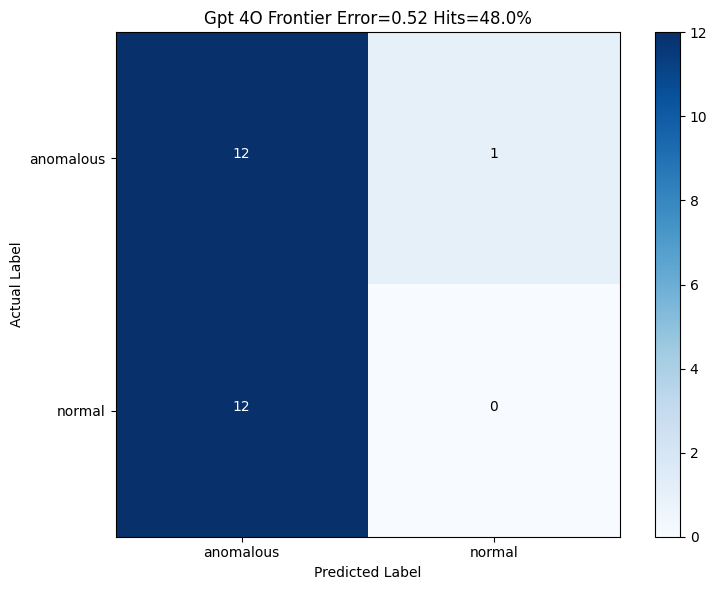

In [62]:
# The function for gpt-4o - the August model
# Note that it cost me about 1-2 cents to run this (pricing may vary by region)
# You can skip this and look at my results instead

Tester.test(gpt_4o_frontier, test)

# We will try a Local Model

# We will try the Emerging models using Openrouter (API provider)



## Lets try Deepskeep with Openrouter!

And now - we put the Deepseek Models to the test.

In [23]:
client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=os.environ['OPENROUTER_API_KEY'],
)


In [68]:
# Lets try hyperbolic using the Open AI library
hyperbolic_client = OpenAI(
  base_url="https://api.hyperbolic.xyz/v1",
  api_key=os.environ['HYPERBOLIC_API_KEY'],
)

In [28]:
completion = hyperbolic_client.chat.completions.create(
  model="deepseek-ai/DeepSeek-R1",
  messages=[
    {
      "role": "user",
      "content": "What is 2+2?"
    }
  ]
)
print(completion)

ChatCompletion(id='991453939cee4c7aa4e62ef19c7de4b4', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="<think>\nOkay, so I need to figure out what 2 plus 2 is. Let me start by recalling basic addition. When you add two numbers, you're combining their quantities. So if I have 2 apples and someone gives me 2 more apples, how many apples do I have in total?\n\nLet's visualize this. Imagine two apples. Now, adding another two apples would make it four apples. So, 2 plus 2 should equal 4. Wait, but maybe I'm oversimplifying. Could there be another way to look at this?\n\nHmm, perhaps in different number systems? Like binary or something? In binary, 2 is represented as 10. So adding 10 (which is 2) and 10 (another 2) would give 100, which is 4 in decimal. So even in binary, 2+2 is 4. That seems consistent.\n\nWhat about in modular arithmetic? If we're using a modulus that's less than or equal to 4, the result might wrap around. For example,

In [69]:
import json

# Use Hyperbolic API to query the deepseek model
def deepseek_via_hyperbolic(item):
    response = hyperbolic_client.chat.completions.create(
        model="deepseek-ai/DeepSeek-R1",
        messages=messages_for(item, similar_situations),
        seed=42
    )
    print(json.dumps(response.__dict__, indent=4, default=str))
    reply = response.choices[0].message.content
    #print(reply)
    return get_result(reply)

In [70]:
test[0].prompt

'How would you classify this sensor data - normal or anomalous?\n\n[{"timestamp": 1738152000, "room": "pillbox", "nodeId": 1, "onOff": true}, {"timestamp": 1738152060, "room": "bedroom", "nodeId": 2, "onOff": true}, {"timestamp": 1738152300, "room": "bathroom", "nodeId": 2, "onOff": true}, {"timestamp": 1738152600, "room": "bathroom", "nodeId": 3, "humidity": 6500}, {"timestamp": 1738152900, "room": "bathroom", "nodeId": 2, "onOff": false}, {"timestamp": 1738153200, "room": "kitchen", "nodeId": 2, "onOff": true}, {"timestamp": 1738153260, "room": "kitchen", "event": "fridge_opened"}, {"timestamp": 1738153800, "room": "kitchen", "nodeId": 2, "onOff": false}, {"timestamp": 1738154100, "room": "livingroom", "nodeId": 2, "onOff": true}, {"timestamp": 1738154400, "room": "livingroom", "nodeId": 1, "occupancy": 1}, {"timestamp": 1738155600, "room": "livingroom", "nodeId": 2, "onOff": false}, {"timestamp": 1738156800, "room": "hall", "nodeId": 1, "occupancy": 1}, {"timestamp": 1738157400, "ro

In [71]:
print(deepseek_via_hyperbolic(test[0]))

{
    "id": "chatcmpl-cUxoyVjDuJJKH89vFvm487",
    "choices": [
        "Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content=\"<think>Okay, let's take a look at this sensor data and see if it's normal or anomalous. The user provided some examples where similar situations were marked as anomalous, so I need to compare this new situation to those.\\n\\nFirst, the data starts with the pillbox being activated, then the bedroom light turns on, followed by the bathroom light. Then there's a humidity sensor reading in the bathroom. After that, the bathroom light turns off, kitchen light on, fridge opened, kitchen light off, living room light on, occupancy detected there, then lights off. Later, there's occupancy in the hall, porch, and then hall occupancy stops. The porch occupancy is reported multiple times as 0 after that.\\n\\nLooking at the previous examples, situations where the pillbox was used followed by movement to other rooms (like bedroom, bat

In [ ]:
# The function for testing deepseek via hyperbolic

Tester.test(deepseek_via_hyperbolic, test)

{
    "id": "chatcmpl-WuDnjCB8WRABfHq5NnwVYx",
    "choices": [
        "Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content=\"<think>Okay, let's take a look at this sensor data and figure out if it's normal or anomalous. The user provided some examples where similar situations were marked as anomalous, so I need to compare this new situation to those.\\n\\nFirst, the data starts with the pillbox being activated (nodeId 1, onOff: true). Then the bedroom light turns on (nodeId 2), followed by the bathroom light. The bathroom also has a humidity sensor reading 6500, which might indicate someone took a shower. After that, the bathroom light turns off, then the kitchen light is turned on, the fridge is opened, and later the kitchen light is turned off. The living room light is turned on, occupancy is detected there, then turned off. The hall and porch have occupancy sensors triggered, with the porch occupancy staying on for a long time (multiple entri